In [2]:
import warnings
warnings.filterwarnings('ignore')

import ast
import math
import pandas as pd
import glob
import numpy as np
import cv2

from simplification.cutil import simplify_coords

import matplotlib.pyplot as plt
import matplotlib.style as style

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import json
import os
import datetime as dt
from tqdm import tqdm
import pandas as pd
import numpy as np
from glob import glob
import re
import ast
import cv2
import csv
import time
import ast
import urllib
from PIL import Image, ImageDraw
from tqdm import tqdm
from dask import bag, threaded
import matplotlib
import matplotlib.pyplot as pltc
import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
from dask import bag, threaded
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.nasnet import NASNetMobile
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.applications import MobileNet
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
import os

Base_Size = 256
data_Directory = 'C:/Users/wangy/OneDrive/Desktop/Doodle/Doodle_Data/'
input_Directory = 'C:/Users/wangy/OneDrive/Desktop/Doodle/Prediction/'
sub_Directory = 'D:/APM/'
num_csv = 100
num_class = 340
size = 64
steps = 2000
batchsize = 256
epochs = 150


print(os.listdir("C:/Users/wangy/OneDrive/Desktop/Doodle"))

['.ipynb_checkpoints', 'cnn.csv', 'CNN.h5', 'CNN.ipynb', 'Doodle_Data', 'Doodle_Recognition_new.ipynb', 'gs.png', 'mobilenet.csv', 'MobileNet.h5', 'MobileNetRGB.ipynb', 'resnet.csv', 'resnet.ipynb', 'resnet50v2.h5', 'sample_submission.csv', 'Screenshot', 'test_simplified.csv', 'vgg16.ipynb']


In [3]:
#Test
def draw_cv2(raw_strokes, size=size, lw=6):
    img = np.zeros((Base_Size, Base_Size))
    for stroke in raw_strokes:
        for i in range(len(stroke[0]) - 1):
            img = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 255, lw)
    return (cv2.resize(img, (size, size))/ 255.)

#Data Augmentation
def image_generator(size, batchsize, ks, lw=6):
    while True:
        for k in np.random.permutation(ks):
            filename = os.path.join(data_Directory, 'train_k{}.csv.gz'.format(k))
            for df in pd.read_csv(filename, chunksize=batchsize):
                x = np.zeros((len(df), size, size))
                df['drawing'] = [ast.literal_eval(pts) for pts in df['drawing'].values]   
                df['drawing'] = df['drawing'].apply(draw_cv2)
                x = np.vstack([a for a in df['drawing']]).reshape((len(df),size,size,1))
                y = tf.keras.utils.to_categorical(df.y, num_classes=num_class)
                yield x, y
                  

def df_to_image_array(df, size=size, lw=6):
    df['drawing'] = [ast.literal_eval(pts) for pts in df['drawing'].values]
    x = np.zeros((len(df), size, size))
    df['drawing'] = df['drawing'].apply(draw_cv2)
    x = np.vstack([a for a in df['drawing']]).reshape((len(df),size,size,1))
    return x

In [4]:
valid_df = pd.read_csv(os.path.join(data_Directory, 'train_k{}.csv.gz'.format(num_csv - 1)), nrows=30000)
x_valid = df_to_image_array(valid_df, size)
y_valid = tf.keras.utils.to_categorical(valid_df.y, num_classes=num_class)
print(x_valid.shape, y_valid.shape)

(30000, 64, 64, 1) (30000, 340)
Validation array memory 0.92 GB


In [5]:
train_datagen = image_generator(size=size, batchsize=batchsize, ks=range(num_csv - 1))

In [6]:
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [8]:
num_classes = num_class

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(size,size,1),padding='same'))
#model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
#model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
#model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

In [9]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001),
                      metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0

In [10]:
callbacks = [
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.3, patience=5,
                      min_delta=0.005, mode='max', verbose=1),
    ModelCheckpoint('CNN.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True, save_weights_only=True)
]


clf = model.fit(
    train_datagen, steps_per_epoch=steps, epochs=epochs, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)

Epoch 1/150
2000/2000 [==============================] - 238s 119ms/step - loss: 2.5361 - categorical_crossentropy: 2.5361 - categorical_accuracy: 0.4452 - top_3_accuracy: 0.6274 - val_loss: 1.9001 - val_categorical_crossentropy: 1.9001 - val_categorical_accuracy: 0.5586 - val_top_3_accuracy: 0.7474
Epoch 2/150
2000/2000 [==============================] - 235s 117ms/step - loss: 1.7821 - categorical_crossentropy: 1.7821 - categorical_accuracy: 0.5841 - top_3_accuracy: 0.7683 - val_loss: 1.6890 - val_categorical_crossentropy: 1.6890 - val_categorical_accuracy: 0.5991 - val_top_3_accuracy: 0.7854
Epoch 3/150
2000/2000 [==============================] - 234s 117ms/step - loss: 1.6296 - categorical_crossentropy: 1.6296 - categorical_accuracy: 0.6151 - top_3_accuracy: 0.7947 - val_loss: 1.5664 - val_categorical_crossentropy: 1.5664 - val_categorical_accuracy: 0.6243 - val_top_3_accuracy: 0.8047
Epoch 4/150
2000/2000 [==============================] - 235s 118ms/step - loss: 1.5524 - categor

2000/2000 [==============================] - 234s 117ms/step - loss: 1.1617 - categorical_crossentropy: 1.1617 - categorical_accuracy: 0.7191 - top_3_accuracy: 0.8684 - val_loss: 1.1963 - val_categorical_crossentropy: 1.1963 - val_categorical_accuracy: 0.7120 - val_top_3_accuracy: 0.8630
Epoch 50/150
2000/2000 [==============================] - 233s 116ms/step - loss: 1.1643 - categorical_crossentropy: 1.1643 - categorical_accuracy: 0.7191 - top_3_accuracy: 0.8683 - val_loss: 1.1962 - val_categorical_crossentropy: 1.1962 - val_categorical_accuracy: 0.7116 - val_top_3_accuracy: 0.8631
Epoch 51/150
2000/2000 [==============================] - 234s 117ms/step - loss: 1.1455 - categorical_crossentropy: 1.1455 - categorical_accuracy: 0.7240 - top_3_accuracy: 0.8711 - val_loss: 1.1962 - val_categorical_crossentropy: 1.1962 - val_categorical_accuracy: 0.7117 - val_top_3_accuracy: 0.8631
Epoch 52/150
2000/2000 [==============================] - 234s 117ms/step - loss: 1.1676 - categorical_cros

Epoch 73/150
2000/2000 [==============================] - ETA: 0s - loss: 1.1513 - categorical_crossentropy: 1.1513 - categorical_accuracy: 0.7220 - top_3_accuracy: 0.8702
Epoch 00073: ReduceLROnPlateau reducing learning rate to 1.7714700373261393e-09.
2000/2000 [==============================] - 234s 117ms/step - loss: 1.1513 - categorical_crossentropy: 1.1513 - categorical_accuracy: 0.7220 - top_3_accuracy: 0.8702 - val_loss: 1.1960 - val_categorical_crossentropy: 1.1960 - val_categorical_accuracy: 0.7115 - val_top_3_accuracy: 0.8632
Epoch 74/150
2000/2000 [==============================] - 233s 117ms/step - loss: 1.1735 - categorical_crossentropy: 1.1735 - categorical_accuracy: 0.7168 - top_3_accuracy: 0.8668 - val_loss: 1.1960 - val_categorical_crossentropy: 1.1960 - val_categorical_accuracy: 0.7115 - val_top_3_accuracy: 0.8632
Epoch 75/150
2000/2000 [==============================] - 234s 117ms/step - loss: 1.1435 - categorical_crossentropy: 1.1435 - categorical_accuracy: 0.7243 -

2000/2000 [==============================] - 235s 117ms/step - loss: 1.1669 - categorical_crossentropy: 1.1669 - categorical_accuracy: 0.7199 - top_3_accuracy: 0.8686 - val_loss: 1.1960 - val_categorical_crossentropy: 1.1960 - val_categorical_accuracy: 0.7115 - val_top_3_accuracy: 0.8632
Epoch 120/150
2000/2000 [==============================] - 234s 117ms/step - loss: 1.1565 - categorical_crossentropy: 1.1565 - categorical_accuracy: 0.7213 - top_3_accuracy: 0.8696 - val_loss: 1.1960 - val_categorical_crossentropy: 1.1960 - val_categorical_accuracy: 0.7115 - val_top_3_accuracy: 0.8632
Epoch 121/150
2000/2000 [==============================] - 234s 117ms/step - loss: 1.1618 - categorical_crossentropy: 1.1618 - categorical_accuracy: 0.7205 - top_3_accuracy: 0.8689 - val_loss: 1.1960 - val_categorical_crossentropy: 1.1960 - val_categorical_accuracy: 0.7115 - val_top_3_accuracy: 0.8632
Epoch 122/150
2000/2000 [==============================] - 234s 117ms/step - loss: 1.1636 - categorical_c

Epoch 143/150
2000/2000 [==============================] - ETA: 0s - loss: 1.1564 - categorical_crossentropy: 1.1564 - categorical_accuracy: 0.7212 - top_3_accuracy: 0.8693
Epoch 00143: ReduceLROnPlateau reducing learning rate to 8.472885923856935e-17.
2000/2000 [==============================] - 234s 117ms/step - loss: 1.1564 - categorical_crossentropy: 1.1564 - categorical_accuracy: 0.7212 - top_3_accuracy: 0.8693 - val_loss: 1.1960 - val_categorical_crossentropy: 1.1960 - val_categorical_accuracy: 0.7115 - val_top_3_accuracy: 0.8632
Epoch 144/150
2000/2000 [==============================] - 234s 117ms/step - loss: 1.1581 - categorical_crossentropy: 1.1581 - categorical_accuracy: 0.7199 - top_3_accuracy: 0.8692 - val_loss: 1.1960 - val_categorical_crossentropy: 1.1960 - val_categorical_accuracy: 0.7115 - val_top_3_accuracy: 0.8632
Epoch 145/150
2000/2000 [==============================] - 238s 119ms/step - loss: 1.1664 - categorical_crossentropy: 1.1664 - categorical_accuracy: 0.7187

In [11]:
def plot_graph(model, title):
    plt.plot(model.history['categorical_accuracy'])
    plt.plot(model.history['val_categorical_accuracy'])
    plt.plot(model.history['top_3_accuracy'])
    plt.plot(model.history['val_top_3_accuracy'])
    plt.title('Accuracy ' + title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation', 'Test Top 3', 'Validation Top 3'], loc='lower right')
    plt.show()
    plt.plot(model.history['categorical_crossentropy'])
    plt.plot(model.history['val_categorical_crossentropy'])
    plt.title('Loss ' + title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

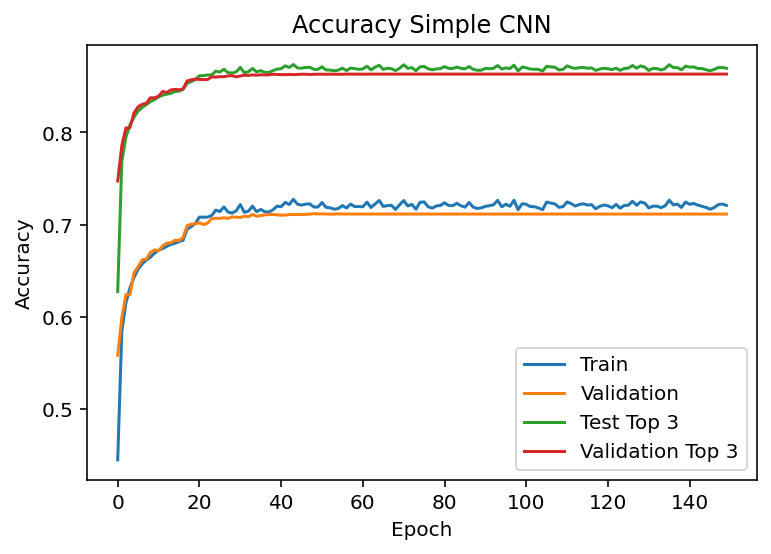

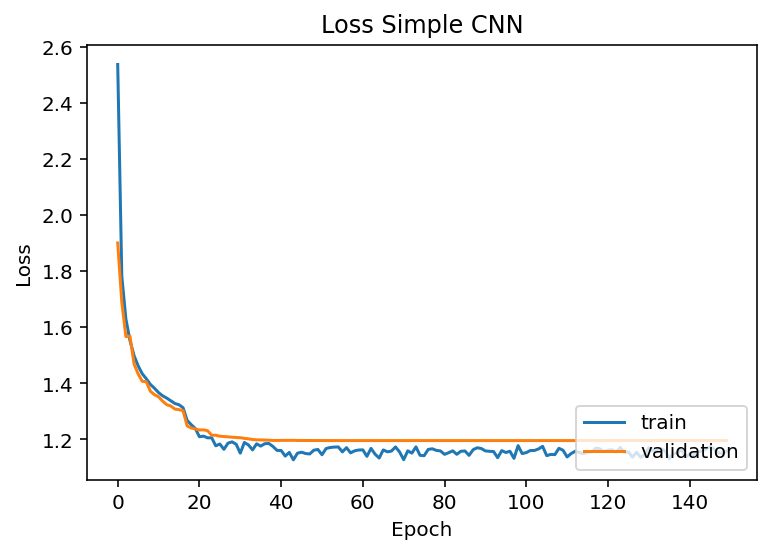

In [12]:
plot_graph(clf, "Simple CNN")

# Turn in for Kaggle

In [13]:
pred_results = []
chunksize = 10000
reader = pd.read_csv(input_Directory + 'test_simplified.csv', chunksize=chunksize)
for chunk in tqdm(reader):
    imgs = df_to_image_array(chunk)
    pred = model.predict(imgs, verbose=1)
    top_3 =  np.argsort(-pred)[:, 0:3]  
    pred_results.append(top_3)
print("Finished test predictions...")

#prepare data for saving
classes_path = os.listdir(sub_Directory + 'train_simplified/')
classes_path = sorted(classes_path, key=lambda s: s.lower())
class_dict = {x[:-4].replace(" ", "_"):i for i, x in enumerate(classes_path)}

reverse_dict = {v: k for k, v in class_dict.items()}
pred_results = np.concatenate(pred_results)
print("Finished data prep...")

preds_df = pd.DataFrame({'first': pred_results[:,0], 'second': pred_results[:,1], 'third': pred_results[:,2]})
preds_df = preds_df.replace(reverse_dict)

0it [00:00, ?it/s]

313/313 [==============================] - 1s 2ms/step


1it [00:05,  5.90s/it]

313/313 [==============================] - 0s 2ms/step


2it [00:11,  5.92s/it]

313/313 [==============================] - 0s 2ms/step


3it [00:17,  5.89s/it]

313/313 [==============================] - 1s 2ms/step


4it [00:23,  5.91s/it]

313/313 [==============================] - 0s 2ms/step


5it [00:29,  5.92s/it]

313/313 [==============================] - 1s 2ms/step


6it [00:35,  5.88s/it]

313/313 [==============================] - 1s 2ms/step


7it [00:41,  5.88s/it]

313/313 [==============================] - 0s 2ms/step


8it [00:47,  5.89s/it]

313/313 [==============================] - 1s 2ms/step


9it [00:53,  5.91s/it]

313/313 [==============================] - 1s 2ms/step


10it [00:59,  5.92s/it]

313/313 [==============================] - 0s 2ms/step


11it [01:04,  5.90s/it]

69/69 [==============================] - 0s 2ms/step


12it [01:06,  5.53s/it]

Finished test predictions...
Finished data prep...


In [14]:
preds_df['words'] = preds_df['first'] + " " + preds_df['second'] + " " + preds_df['third']

sub = pd.read_csv(input_Directory + 'sample_submission.csv', index_col=['key_id'])
sub['word'] = preds_df.words.values
sub.to_csv('cnn.csv')
sub.head()

,word
key_id,
9000003627287624,radio stereo stove
9000010688666847,hockey_puck belt pool
9000023642890129,The_Great_Wall_of_China castle camel
9000038588854897,mountain tent The_Eiffel_Tower
9000052667981386,fireplace leaf campfire
